# 単回帰分析

目的変数 $y$ を一つの変数 $x$ で予測する 

## モデル
目的変数 $y$ と変数 $x$ の関係を下記の一次式で表せるとする
$$
    y = ax + b
$$

ここで $a$, $b$ はモデルの**パラメータ**と呼ばれ、最適なパラメータを求めるのが回帰分析となる

## 損失関数
サンプル数$N$に関して、$y_{i}$ を実測値、 $\hat{y_{i}}$ をモデルによって算出される予測値とした時、下記の式で求められる値が少ないほどよく予測できていると言える

$$
\mathcal{L} = \sum_{i=1}^{N}{(y_{i} - \hat{y_{i}})^2}
$$

つまり、**最適なパラメータ** = **損失関数を最小にするパラメータ**

## 中心化
実測値による目的変数と変数の平均をそれぞれ各目的変数 $y$, $x$から引いて考えるとモデルが
$$
y = ax
$$
となり、求めるべきパラメータが $a$ のみとなる

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
x = np.array([1, 2, 4, 6, 8, 10])
y = np.array([15, 20, 30, 40, 50, 60])

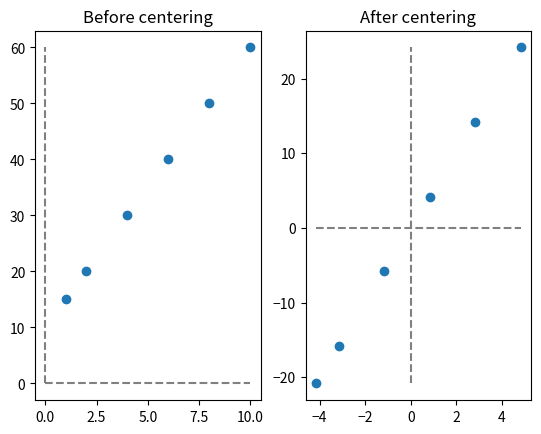

In [3]:
fig = plt.figure()
a1 = fig.add_subplot(1, 2, 1)
a1.scatter(x, y)
a1.plot(np.array([0, x.max()]), np.array([0, 0]), linestyle='dashed', color='grey')
a1.plot(np.array([0, 0]), np.array([0, y.max()]), linestyle='dashed', color='grey')
a1.set_title('Before centering')

a2 = fig.add_subplot(1, 2, 2)
a2.scatter(x - x.mean(), y - y.mean())
a2.plot(np.array([(x - x.mean()).min(), (x - x.mean()).max()]), np.array([0, 0]), linestyle='dashed', color='grey')
a2.plot(np.array([0, 0]), np.array([(y - y.mean()).min(), (y - y.mean()).max()]), linestyle='dashed', color='grey')
a2.set_title('After centering')
plt.show()

## 損失関数を最小化するパラメータを見つける
損失関数の式変形
$$
\begin{eqnarray}
\mathcal{L} &=& \sum_{i=1}^{N}{ (y_i - \hat{y_i})^2 } \\
&=& \sum_{i=1}^{N}{ (y_i - ax_i)^2 } \\
&=& \sum_{i=1}^{N}{ {y_i}^2 - 2{x_i}{y_i}a + {{x_i}^2}a^2 } \\
&=& \sum_{i=1}^{N}{ {y_i}^2 } -2(\sum_{i=1}^{N}{ {x_i}{y_i} })a + (\sum_{i=1}^{N}{ {x_i}^2 })a^2
\end{eqnarray}
$$

つまり、下記を満たす $a$ を算出する
$$
\frac{\partial}{\partial a}{(\sum_{i=1}^{N}{ {y_i}^2 } -2(\sum_{i=1}^{N}{ {x_i}{y_i} })a + (\sum_{i=1}^{N}{ {x_i}^2 })a^2)} = 0
$$

求める
$$
\begin{eqnarray}
\frac{\partial}{\partial a}{(\sum_{i=1}^{N}{ {y_i}^2 } -2(\sum_{i=1}^{N}{ {x_i}{y_i} })a + (\sum_{i=1}^{N}{ {x_i}^2 })a^2)} &=& 0 \\
\to{ \frac{\partial}{\partial a}{ \sum_{i=1}^{N}{ {y_i}^2 } } -\frac{\partial}{\partial a}{ 2(\sum_{i=1}^{N}{ {x_i}{y_i} })a } + \frac{\partial}{\partial a}{(\sum_{i=1}^{N}{ {x_i}^2 })a^2}} &=& 0 \\
\to{ -2\sum_{i=1}^{N}{ {x_i}{y_i} } + 2(\sum_{i=1}^{N}{ {x_i}^2 })a } &=& 0  \\
\to{ (\sum_{i=1}^{N}{ {x_i}^2 })a} &=& \sum_{i=1}^{N}{ {x_i}{y_i} }
\end{eqnarray}
$$

よって
$$
a = \frac{\sum_{i=1}^{N}{ {x_i}{y_i} }}{\sum_{i=1}^{N}{ {x_i}^2 }}
$$

## 実際に求めてみる

In [4]:
df = pd.DataFrame({'x': x, 'y': y})
df_mean = df.mean()
df_c = df - df_mean
df_x_c = df_c['x']
df_y_c = df_c['y']
a = (df_x_c * df_y_c).sum() / (df_x_c * df_x_c).sum()

In [5]:
def predict(x):
    return a * x + df_mean['y']

In [6]:
predict(df_x_c)

0    15.0
1    20.0
2    30.0
3    40.0
4    50.0
5    60.0
Name: x, dtype: float64

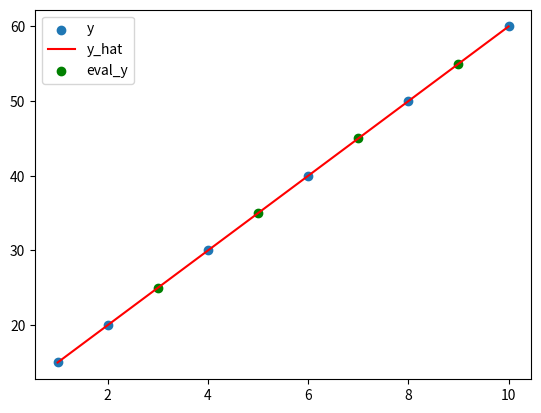

In [7]:
df_x = df_x_c + df_mean['x']
df_y = df_y_c + df_mean['y']
plt.scatter(df_x, df_y, label='y')
plt.plot(df_x, predict(df_x_c), color='red', label='y_hat')

eval_x = np.array([3, 5, 7, 9])
eval_x_c = eval_x - df_mean['x']
plt.scatter(eval_x, predict(eval_x_c), label='eval_y', color='green')

plt.legend()
plt.show()

## 実際のデータを使ってシミュレーション
TPC-Hのデータを使って考える

`LINEITEM`の`QUANTITY`から`EXTENDED_PRICE`を予測する

In [8]:
import os
import sys
import seaborn as sns
from pathlib import Path
sys.path.append(os.path.dirname(Path().resolve()))

from modules.snowflake import Snowflake
from snowflake.snowpark.functions import col

In [9]:
snowflake = Snowflake()

In [10]:
lineitem_df = snowflake.fetch_dataframe('SNOWFLAKE_SAMPLE_DATA.TPCH_SF1.LINEITEM')

In [11]:
lineitem_pd = lineitem_df.filter(
    col('L_LINENUMBER') == 1
).select(
    col('L_QUANTITY').alias('QUANTITY'),
    col('L_EXTENDEDPRICE').alias('EXTENDED_PRICE')
).to_pandas()

In [12]:
len(lineitem_pd)

1500000

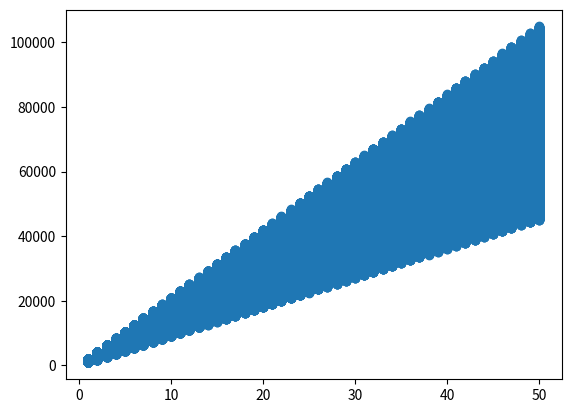

In [13]:
# `QUANTITY`と`EXTENDED_PRICE`の関係を散布図に表す
plt.scatter(lineitem_pd['QUANTITY'], lineitem_pd['EXTENDED_PRICE'])
plt.show()

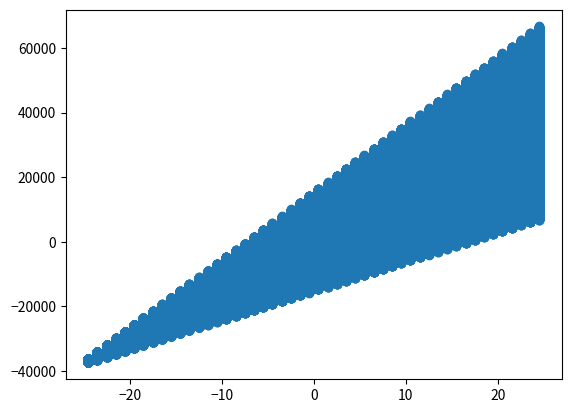

In [14]:
# センタリング
## 平均の算出
mean_lineitem_pd = lineitem_pd.mean()
centering_lineitem_pd = lineitem_pd - mean_lineitem_pd

centering_quantities = centering_lineitem_pd['QUANTITY']
centering_extended_prices = centering_lineitem_pd['EXTENDED_PRICE']

# センタリング後の散布図
plt.scatter(centering_quantities, centering_extended_prices)
plt.show()

In [15]:
## 回帰直線の傾きを求める
a = (centering_quantities * centering_extended_prices).sum() / (centering_quantities * centering_quantities).sum()

In [16]:
def predict(x):
    return a * x + mean_lineitem_pd['EXTENDED_PRICE']

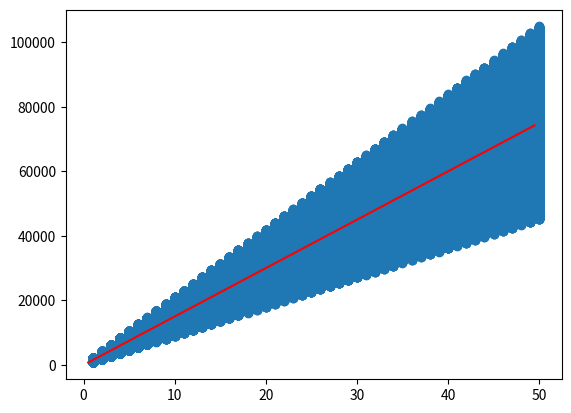

In [17]:
centering_x = np.array(range(int(centering_lineitem_pd['QUANTITY'].min()) - 1, int(centering_lineitem_pd['QUANTITY'].max()) + 1))
x = centering_x + mean_lineitem_pd['QUANTITY']
y = predict(centering_x)

# 実データと回帰直線を可視化する
plt.scatter(lineitem_pd['QUANTITY'], lineitem_pd['EXTENDED_PRICE'])
plt.plot(x, y, color='red')
plt.show()

In [52]:
x = np.arange(0, 50, 1)
data = [4 * i + 50 + random.uniform(-10, 10) for i in x]

In [121]:
pd.DataFrame({'x': pd.Series(x), 'y': pd.Series(data)})

,x,y
0,0,45.010787
1,1,62.315182
2,2,66.829897
3,3,55.684884
4,4,74.046407
5,5,77.697523
6,6,77.101129
7,7,81.514224
8,8,90.059299
9,9,81.304910


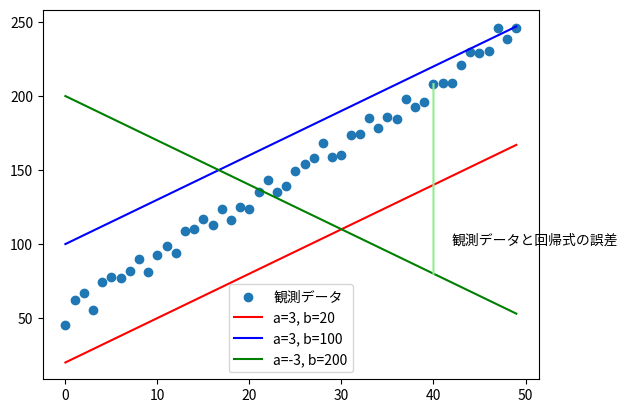

In [84]:
import random
import numpy as np

plt.scatter(x, data, label='観測データ')

plt.plot(x, [3 * xs + 20 for xs in x], color='red', label='a=3, b=20')
plt.plot(x, [3 * xs + 100 for xs in x], color='blue', label='a=3, b=100')
plt.plot(x, [-3 * xs + 200 for xs in x], color='green', label='a=-3, b=200')

y1 = np.arange(80, 208.2, 0.1)
plt.plot(np.zeros(len(y1)) + 40, y1, color='lightgreen')
plt.annotate('観測データと回帰式の誤差', xy=(42, 100), size=10, color='black')

plt.legend()
plt.show()

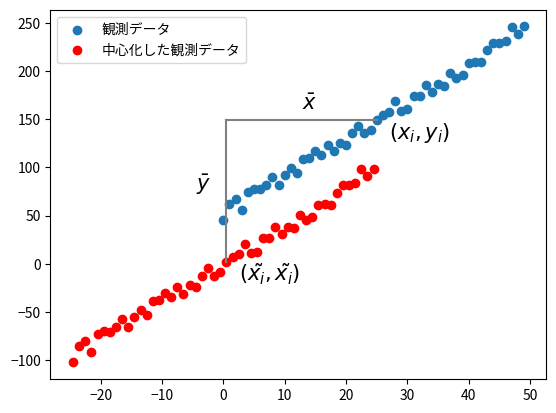

In [118]:
plt.scatter(x, data, label='観測データ')
plt.scatter(x - np.mean(x), data - np.mean(data), label='中心化した観測データ', color='red')

x1 = x[25]
y1 = data[25]
x1_c = x1 - np.mean(x)
y1_c = y1 - np.mean(data)
plt.plot([x1_c, x1], [y1, y1], color='gray')
plt.plot([x1_c, x1_c], [y1_c, y1], color='gray')

plt.annotate(r"$(x_i, y_i)$", xy=(x1 + 2, y1 - 20), size=15, color='black')
plt.annotate(r"$(\tilde{ x_i }, \tilde{ x_i })$", xy=(x1_c + 2, y1_c - 20), size=15, color='black')

plt.annotate(r"$\bar{x}$", xy=((x1_c + x1) / 2 , y1 + 10), size=15, color='black')
plt.annotate(r"$\bar{y}$", xy=(x1_c - 5, (y1_c + y1) / 2), size=15, color='black')


plt.legend()
plt.show()

In [122]:
pd.DataFrame({'x_c': pd.Series(x - np.mean(x)), 'y_c': pd.Series(data - np.mean(data))})

,x_c,y_c
0,-24.5,-102.428666
1,-23.5,-85.124271
2,-22.5,-80.609556
3,-21.5,-91.754568
4,-20.5,-73.393046
5,-19.5,-69.741929
6,-18.5,-70.338324
7,-17.5,-65.925229
8,-16.5,-57.380154
9,-15.5,-66.134543


In [124]:
pd.Series(x - np.mean(x)).values, pd.Series(data - np.mean(data))

t1 = 0
for _x, _y in zip(pd.Series(x - np.mean(x)).values, pd.Series(data - np.mean(data))):
    t1 += _x*_y

t2 = 0
for _x in pd.Series(x - np.mean(x)).values:
    t2 += _x*_x

In [129]:
np.mean(data) - (t1 / t2) * np.mean(x) 

53.21027916056161

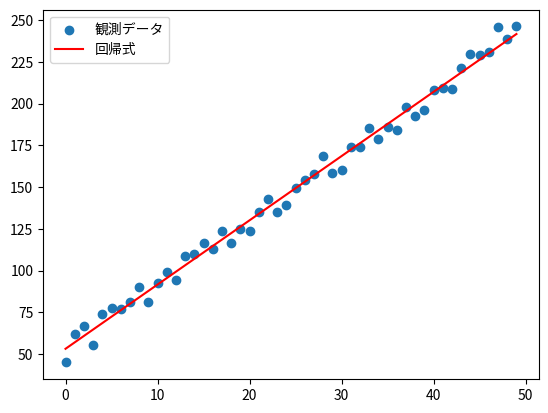

In [130]:
a = t1 / t2
b = np.mean(data) - a * np.mean(x) 

plt.scatter(x, data, label='観測データ')
plt.plot(x, [a * xs + b for xs in x], color='red', label='回帰式')

plt.legend()
plt.show()

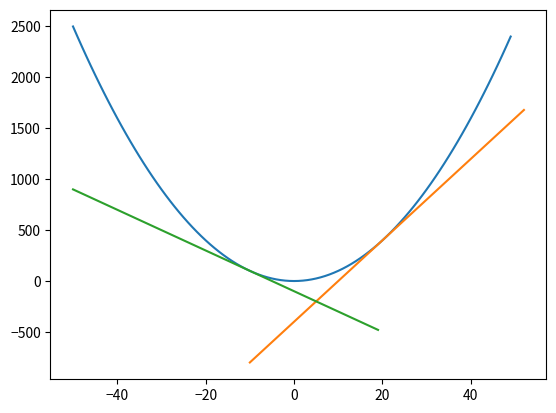

In [43]:
x = np.arange(-50, 50, 1)
plt.plot(x, [xs ** 2 for xs in x])

x1 = np.arange(-10, 53, 1)
plt.plot(x1, 40 * x1 - 400)

x2 = np.arange(-50, 20, 1)
plt.plot(x2, -20 * x2 - 100)

plt.show()